#  Fraud Detection ML Pipeline - Advanced Version

## Step 0: imports

In [407]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix
from imblearn.over_sampling import SMOTE
import shap
import optuna
from sklearn.feature_extraction.text import TfidfVectorizer

##  Step1: Database connection


In [408]:
DB_URI = os.getenv('DB_URI', 'sqlite:///drafts1.db')
engine = create_engine(DB_URI)

# 1. Load & Clean Data

In [409]:
df = pd.read_sql('SELECT * FROM drafts', engine)
df.head()

,traite_num,bank,amount_digits,amount_words,rib,signature_detected,barcode_validates_traite,date_created,date_due,place_created,drawer_name,payer_name_address,fraud_label
0,123005401501,Traore SARL,6574.555,six mille cinq cent soixante-quatorze dinars z...,04332181960013389057,1,1,2024-08-28,2025-05-26,Gallet,Yves Traore,"10, rue Rey 64716 Saint Michelle",0
1,771590378377,Vasseur,5831.828,cinq mille huit cent trente et un dinars zéro ...,86379402654235116148,1,1,2024-11-15,2025-05-26,Saint Marthe,Marianne Lopes,"21, rue Agathe Barre 77370 Sainte Élise",0
2,416278088865,Courtois SARL,3910.304,trois mille neuf cent dix dinars zéro trois zé...,59407816184959310303,1,1,2025-04-12,2025-05-26,Olivier-sur-Fischer,Alphonse Peltier,"4, avenue Lopes 58750 Goncalves",0
3,388136971784,Leconte Da Costa et Fils,7844.149,sept mille huit cent quarante-quatre dinars zé...,13164752553419283230,1,1,2025-05-23,2025-05-26,Bousquet-sur-Picard,Jacqueline Goncalves-Pinto,"135, rue Gomes 51374 Saint Hélèneboeuf",0
4,718172762479,Delaunay,4891.472,quatre mille huit cent quatre-vingt-onze dinar...,48350305641395376723,1,1,2025-05-03,2025-05-26,Aubry,Gérard Vallet,"769, rue Guillaume Grégoire 63193 Saint Honoré",0


In [410]:
for col in ['bank', 'place_created', 'drawer_name', 'payer_name_address', 'amount_words']:
    df[col] = df[col].astype(str).str.strip()

# Convert dates and numeric
for col in ['date_created', 'date_due']:
    df[col] = pd.to_datetime(df[col], errors='coerce')
df['amount_digits'] = pd.to_numeric(df['amount_digits'], errors='coerce')

# Filter invalid
df = df.dropna(subset=['amount_digits', 'date_created', 'date_due', 'rib'])
df['gap_days'] = (df['date_due'] - df['date_created']).dt.days
df['fraud_label'] = df['fraud_label'].astype(int)
df.shape
df.head()

,traite_num,bank,amount_digits,amount_words,rib,signature_detected,barcode_validates_traite,date_created,date_due,place_created,drawer_name,payer_name_address,fraud_label,gap_days
0,123005401501,Traore SARL,6574.555,six mille cinq cent soixante-quatorze dinars z...,04332181960013389057,1,1,2024-08-28,2025-05-26,Gallet,Yves Traore,"10, rue Rey 64716 Saint Michelle",0,271
1,771590378377,Vasseur,5831.828,cinq mille huit cent trente et un dinars zéro ...,86379402654235116148,1,1,2024-11-15,2025-05-26,Saint Marthe,Marianne Lopes,"21, rue Agathe Barre 77370 Sainte Élise",0,192
2,416278088865,Courtois SARL,3910.304,trois mille neuf cent dix dinars zéro trois zé...,59407816184959310303,1,1,2025-04-12,2025-05-26,Olivier-sur-Fischer,Alphonse Peltier,"4, avenue Lopes 58750 Goncalves",0,44
3,388136971784,Leconte Da Costa et Fils,7844.149,sept mille huit cent quarante-quatre dinars zé...,13164752553419283230,1,1,2025-05-23,2025-05-26,Bousquet-sur-Picard,Jacqueline Goncalves-Pinto,"135, rue Gomes 51374 Saint Hélèneboeuf",0,3
4,718172762479,Delaunay,4891.472,quatre mille huit cent quatre-vingt-onze dinar...,48350305641395376723,1,1,2025-05-03,2025-05-26,Aubry,Gérard Vallet,"769, rue Guillaume Grégoire 63193 Saint Honoré",0,23


# 2. Exploratory Data Analysis

### Fraud distribution


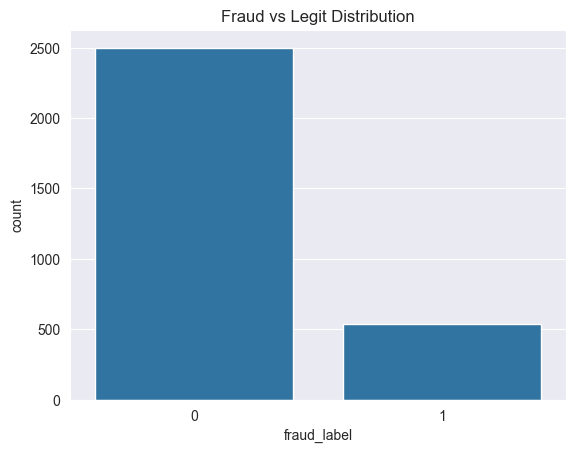

In [411]:
sns.countplot(x='fraud_label', data=df)
plt.title('Fraud vs Legit Distribution')
plt.show()

# Amount distribution


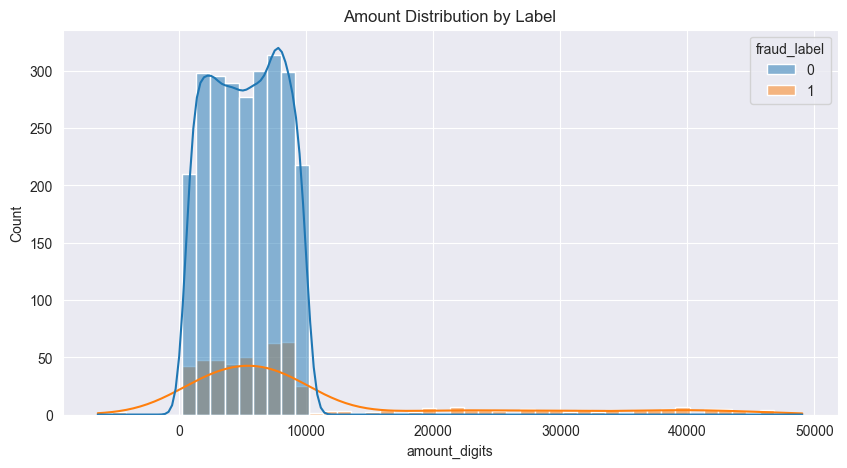

In [412]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='amount_digits', hue='fraud_label', bins=50, kde=True)
plt.title('Amount Distribution by Label')
plt.show()

# Time gap


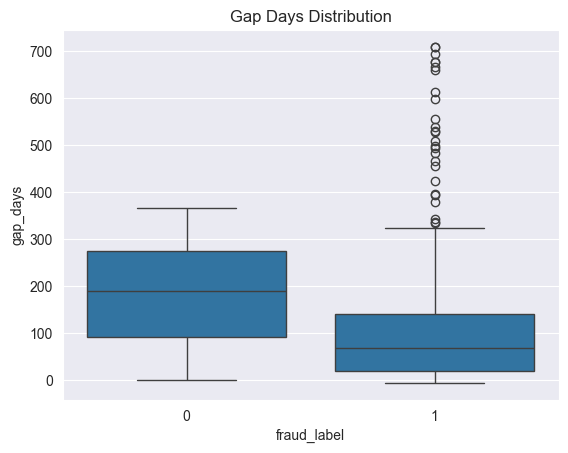

In [413]:
sns.boxplot(x='fraud_label', y='gap_days', data=df)
plt.title('Gap Days Distribution')
plt.show()


# Correlation


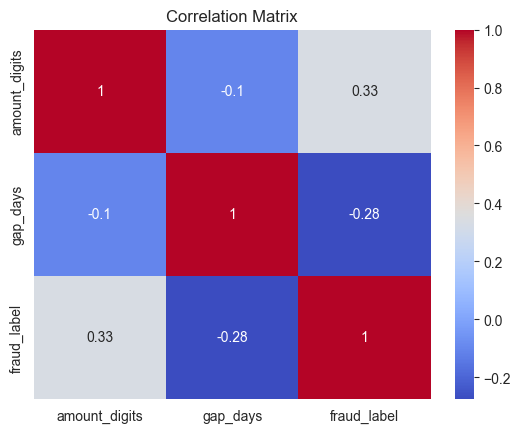

In [414]:
numeric_cols = ['amount_digits', 'gap_days']
sns.heatmap(df[numeric_cols + ['fraud_label']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Violin plots for richer distribution insights


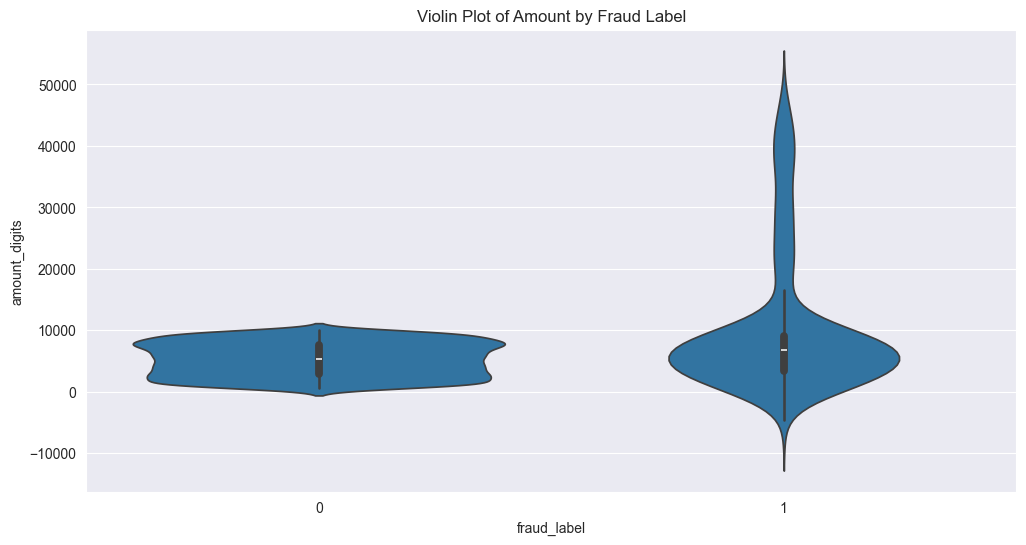

In [415]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='fraud_label', y='amount_digits', data=df)
plt.title('Violin Plot of Amount by Fraud Label')
plt.show()

# Pair plot for selected numeric features


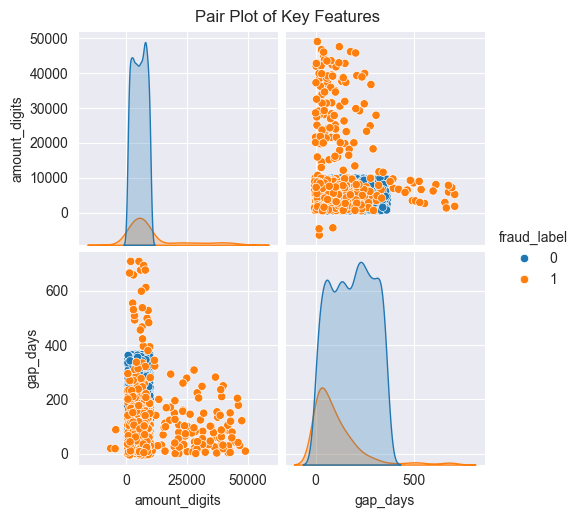

In [416]:
sns.pairplot(df[['amount_digits', 'gap_days', 'fraud_label']], hue='fraud_label')
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()

# signature detected plot


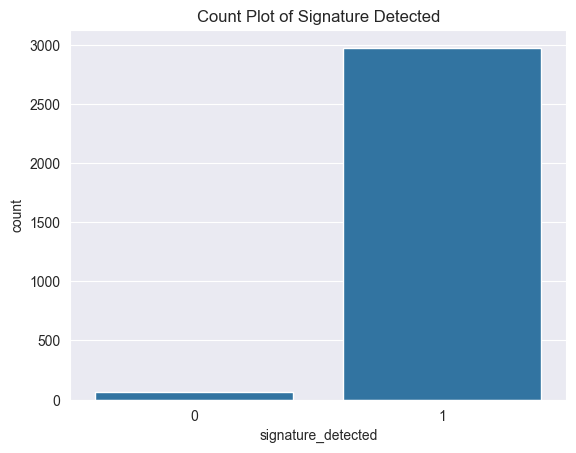

In [417]:
sns.countplot(x="signature_detected",data=df)
plt.title('Count Plot of Signature Detected')
plt.show()

# Count plot of RIB validity


Valid RIBs:   2982
Invalid RIBs: 54


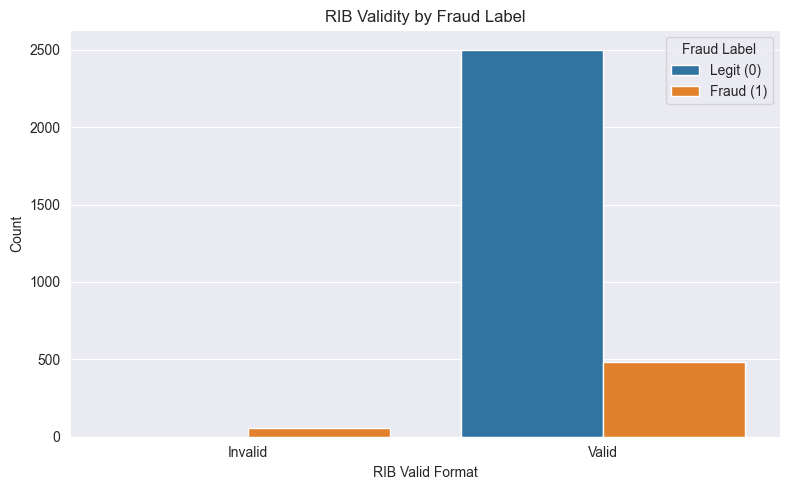

In [418]:
def is_valid_rib(v: str) -> bool:
    s = v.replace(' ', '').replace('-', '')
    if len(s) != 20:
        return False
    n = int(s[:-2] + '00')
    chk = 97 - (n % 97)
    return chk == int(s[-2:])
df['rib_valid'] = df['rib'].apply(is_valid_rib)
counts = df['rib_valid'].value_counts()
print(f"Valid RIBs:   {counts.get(True, 0)}")
print(f"Invalid RIBs: {counts.get(False, 0)}")
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='rib_valid',           # now a boolean column
    hue='fraud_label'        # 0 = legit, 1 = fraud
)
plt.title('RIB Validity by Fraud Label')
plt.xlabel('RIB Valid Format')
plt.ylabel('Count')
plt.xticks([0,1], ['Invalid', 'Valid'])
plt.legend(title='Fraud Label', labels=['Legit (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

## Step 3: Feature Engineering

In [419]:
def amount_to_words_fr(x):
    from num2words import num2words
    return num2words(x, lang='fr').replace('virgule', 'dinars zéro')

def is_valid_rib(v):
    s = v.replace(' ', '').replace('-', '')
    if len(s) != 20:
        return False
    n = int(s[:-2] + '00')
    chk = 97 - (n % 97)
    return chk == int(s[-2:])

# Feature columns

In [420]:
df['amount_words_match'] = (df['amount_words'] == df['amount_digits'].apply(amount_to_words_fr)).astype(int)
df['sig_missing'] = (~df['signature_detected']).astype(int)
df['barcode_bad'] = (~df['barcode_validates_traite']).astype(int)
df['rib_invalid'] = (~df['rib'].apply(is_valid_rib)).astype(int)
df['payer_len'] = df['payer_name_address'].str.len()
df['drawer_len'] = df['drawer_name'].str.len()

feature_cols = ['amount_digits', 'gap_days', 'amount_words_match', 'sig_missing', 'barcode_bad', 'rib_invalid', 'payer_len', 'drawer_len']
X = df[feature_cols]
y = df['fraud_label']

In [421]:
X

,amount_digits,gap_days,amount_words_match,sig_missing,barcode_bad,rib_invalid,payer_len,drawer_len
0,6574.555,271,1,-2,-2,0,32,11
1,5831.828,192,1,-2,-2,0,39,14
2,3910.304,44,1,-2,-2,0,31,16
3,7844.149,3,1,-2,-2,0,38,26
4,4891.472,23,1,-2,-2,0,46,13
...,...,...,...,...,...,...,...,...
3031,8768.746,8,1,-2,-2,1,34,15
3032,8400.434,23,1,-2,-2,1,34,11
3033,7364.532,102,1,-2,-1,0,35,17
3034,7251.600,3,1,-2,-1,0,31,12


In [422]:
y

0       0
1       0
2       0
3       0
4       0
       ..
3031    1
3032    1
3033    1
3034    1
3035    1
Name: fraud_label, Length: 3036, dtype: int32

## Step 4: Data Preprocessing Pipeline


In [423]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_features = ['amount_digits', 'gap_days', 'payer_len', 'drawer_len']
categorical_features = ['sig_missing', 'barcode_bad', 'rib_invalid', 'amount_words_match']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', 'passthrough', categorical_features)
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Step 5: TensorFlow Neural Network Classifier

In [424]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7862 - loss: 0.6011 - val_accuracy: 0.8519 - val_loss: 0.4510
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.4154 - val_accuracy: 0.8539 - val_loss: 0.3833
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3539 - val_accuracy: 0.8560 - val_loss: 0.3653
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.3591 - val_accuracy: 0.8601 - val_loss: 0.3549
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8490 - loss: 0.3444 - val_accuracy: 0.8621 - val_loss: 0.3447
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8671 - loss: 0.3448 - val_accuracy: 0.8683 - val_loss: 0.3353
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8670 - loss: 0.3355 - val_accuracy: 0.8683 - val_loss: 0.3252
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8797 - loss: 0.3101 - val_accuracy: 0.8683 - val_loss:

## Step 6: Evaluation


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.92      1.00      0.95       501
           1       0.97      0.57      0.72       107

    accuracy                           0.92       608
   macro avg       0.94      0.78      0.84       608
weighted avg       0.92      0.92      0.91       608

ROC AUC: 0.9419105713806033


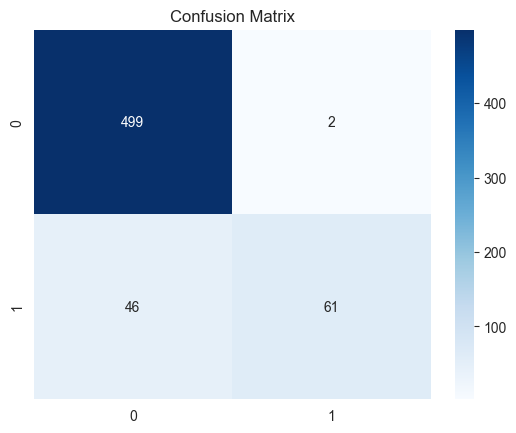

In [425]:
from sklearn.metrics import classification_report

preds = model.predict(X_test_scaled).flatten()
preds_label = (preds > 0.5).astype(int)

print(classification_report(y_test, preds_label))
print("ROC AUC:", roc_auc_score(y_test, preds))

sns.heatmap(confusion_matrix(y_test, preds_label), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Step 9: SHAP Explainability (on XGBoost for variety)


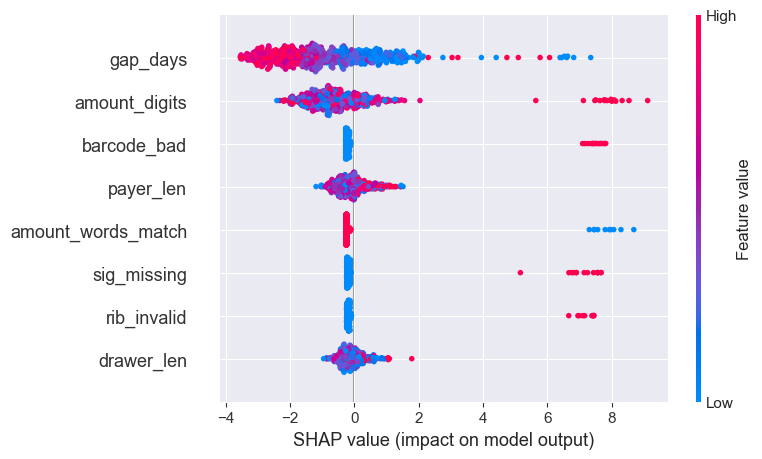

In [426]:
import  xgboost as xgb

xgb_clf = xgb.XGBClassifier( eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)



## Step 7: Save Models


In [427]:
model.save('model_tf1.keras')   # or: model.save('model_tf', save_format='tf')
joblib.dump(preprocessor, './preprocessor1.pkl')
joblib.dump(xgb_clf, './xgb_model1.pkl')

['./xgb_model1.pkl']

## Step 8: Inference Template


In [428]:
def predict_fraud(new_data):
    model = tf.keras.models.load_model('model_tf1.keras')
    preprocessor = joblib.load('./preprocessor1.pkl')
    X_new = pd.DataFrame([new_data])[feature_cols]
    X_scaled = preprocessor.transform(X_new)
    prob = float(model.predict(X_scaled)[0][0])
    return {'fraud_score': prob, 'fraud_label': prob > 0.5}

In [429]:
def predict_from_raw(raw_data):
    from num2words import num2words

    def amount_to_words_fr(x):
        return num2words(x, lang='fr').replace('virgule', 'dinars zéro')

    def is_valid_rib(v):
        s = str(v).replace(' ', '').replace('-', '')
        if len(s) != 20 or not s.isdigit():
            return False
        try:
            n = int(s[:-2] + '00')
            chk = 97 - (n % 97)
            return chk == int(s[-2:])
        except:
            return False

    # Derive features
    try:
        raw_data['date_created'] = pd.to_datetime(raw_data['date_created'])
        raw_data['date_due'] = pd.to_datetime(raw_data['date_due'])
        gap_days = (raw_data['date_due'] - raw_data['date_created']).days
    except:
        gap_days = 0

    features = {
        'amount_digits': raw_data['amount_digits'],
        'gap_days': gap_days,
        'amount_words_match': int(raw_data['amount_words'] == amount_to_words_fr(raw_data['amount_digits'])),
        'sig_missing': int(not raw_data.get('signature_detected', True)),
        'barcode_bad': int(not raw_data.get('barcode_validates_traite', True)),
        'rib_invalid': int(not is_valid_rib(raw_data['rib'])),
        'payer_len': len(str(raw_data.get('payer_name_address', ''))),
        'drawer_len': len(str(raw_data.get('drawer_name', '')))
    }

    # Model + prediction
    model = tf.keras.models.load_model('model_tf1.keras')
    preprocessor = joblib.load('preprocessor1.pkl')
    X_new = pd.DataFrame([features])
    X_scaled = preprocessor.transform(X_new)
    prob = float(model.predict(X_scaled)[0][0])
    print(prob)
    return {'fraud_score': round(prob, 3), 'fraud_label': prob > 0.5}




In [430]:
legit_example_2 = {
    'date_created': '2024-03-10',
    'date_due': '2024-03-20',
    'amount_digits': 1450.50,
    'amount_words': 'mille quatre cent cinquante dinars zéro',
    'signature_detected': True,
    'barcode_validates_traite': True,
    'rib': '03902013011500052013',
    'payer_name_address': 'Société Générale, 45 avenue Bourguiba, Tunis',
    'drawer_name': 'Tunis Commerce International'
}

predict_from_raw(legit_example_2)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.9990894794464111


{'fraud_score': 0.999, 'fraud_label': True}

In [432]:
legit_example_2 = {
    'date_created': '2024-03-10',
    'date_due': '2024-03-20',
    'amount_digits': 1451.50,
    'amount_words': 'mille quatre cent cinquante dinars zéro',
    'signature_detected': True,
    'barcode_validates_traite': True,
    'rib': '12345678901234567890',  # valid format assumed
    'payer_name_address': 'Société Générale, 45 avenue Bourguiba, Tunis',
    'drawer_name': 'Tunis Commerce International'
}

print(predict_from_raw(legit_example_2))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
0.9990895986557007
{'fraud_score': 0.999, 'fraud_label': True}
